# Outline


<p><a name="sections"></a></p>


## Sections

- <a href="#dat">1. Data </a><br>
    - <a href="#vis">Visualization</a><br>
- <a href="#mod">2. Model (Quantity, Revenue, Inventory)</a><br>
    - <a href="#btv">Build and Train a VAR model</a><br>
    - <a href="#ira">Impulse Responses Analysis</a><br>
    - <a href="#sel">Model Selection Through Information Criterion</a><br>
    - <a href="#var">Traning the VAR model through VARMAX with order = (p,0)</a><br>
- <a href="#mod2">3. Model by Category</a><br>
    - <a href="#btv2">Build and Train a VAR model</a><br>
    - <a href="#ira2">Impulse Responses Analysis</a><br>
    - <a href="#sel2">Model Selection Through Information Criterion</a><br>
    - <a href="#var2">Traning the VAR model through VARMAX with order = (p,0)</a><br>

In [88]:
#create environment
import numpy as np
import pandas as pd
import scipy as sci
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from copy import deepcopy
from statsmodels.formula.api import ols
import statsmodels.api as sm
from datetime import datetime
from pandas.plotting import scatter_matrix
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
import warnings
pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore', module = '', message='The pandas.core.datetools module is deprecated')

<p><a name="dat"></a></p>
## 1. Data

In [89]:
uno_tsdf = pd.read_pickle('uno_tsdf.pkl')
uno_tsdf_cat = pd.read_pickle('uno_tsdf_cat.pkl')
uno_tsdf.head()

,Quantity,Revenue,Inventory
Date,,,
2016-01-04,22947.0,99461.25,-14709.0
2016-01-05,56844.0,263037.00,-310124.0
2016-01-06,5900.0,24272.41,-29685.0
2016-01-07,13615.0,57446.90,-177176.0
2016-01-08,15259.0,71866.05,-102222.0


In [90]:
uno_tsdf.describe()

,Quantity,Revenue,Inventory
count,1004.000000,1.004000e+03,1004.000000
mean,12514.811753,4.152775e+04,2091.153386
std,19061.592934,5.727752e+04,62824.625303
min,-12913.000000,7.200000e+01,-310124.000000
25%,3444.000000,1.265336e+04,-13161.500000
50%,7889.000000,2.696441e+04,345.500000
75%,15720.000000,5.066800e+04,11315.000000
max,406543.000000,1.221166e+06,610051.000000


<p><a name="vis"></a></p>
### Visualization 

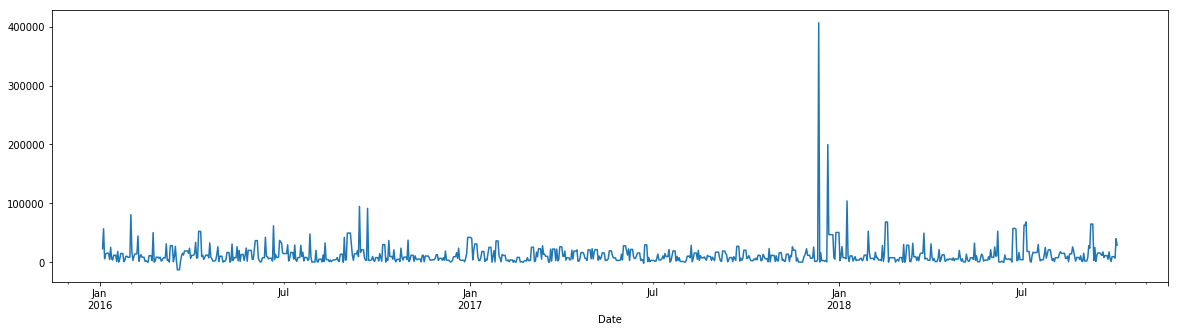

In [94]:
uno_tsdf['Quantity'].plot()
plt.rcParams['figure.figsize']=(20,5)

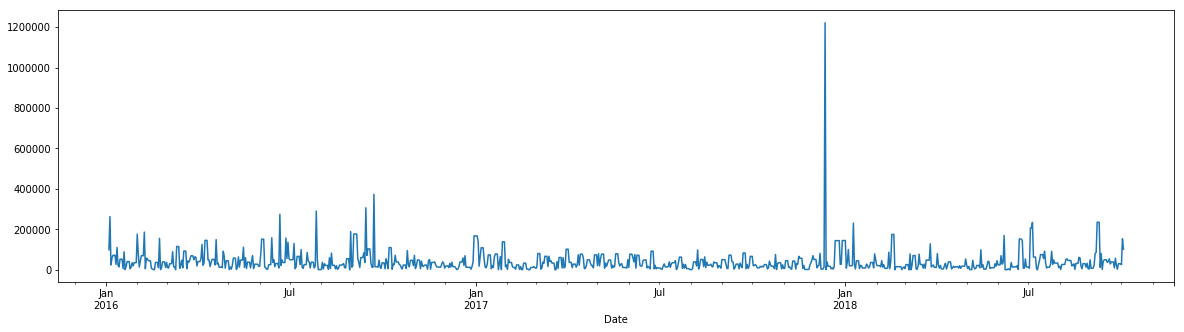

In [95]:
uno_tsdf['Revenue'].plot()
plt.rcParams['figure.figsize']=(20,5)

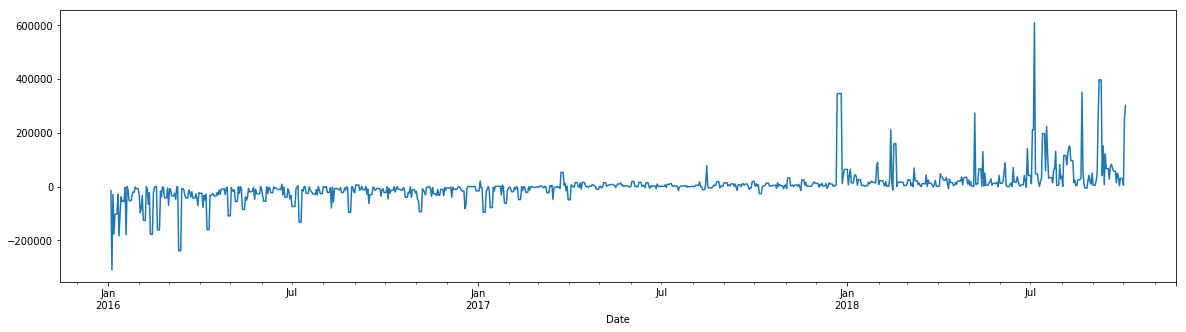

In [96]:
uno_tsdf['Inventory'].plot(x='Date')
plt.rcParams['figure.figsize']=(20,5)

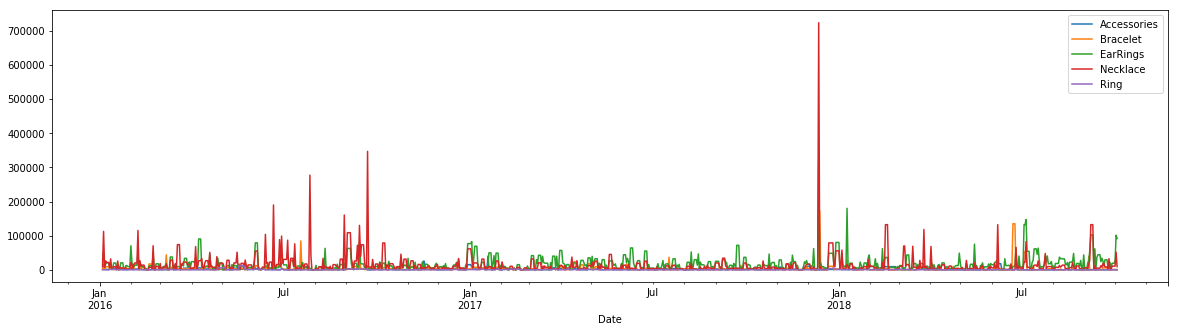

In [97]:
uno_tsdf_cat.plot()
plt.rcParams['figure.figsize']=(20,5)

<p><a name="mod"></a></p>
## 2. Model (Quantity, Revenue, Inventory)

In [98]:
#daily return
ret_var = np.log(uno_tsdf.drop(columns='Inventory')).diff().iloc[1:]
ret_var    = ret_var.fillna(method='pad')
ret_train  = ret_var.copy()
ret_train.index = pd.to_datetime(ret_train.index)
ret_train.head()

/Users/hee-wonchang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


,Quantity,Revenue
Date,,
2016-01-05,0.907123,0.972527
2016-01-06,-2.265358,-2.382954
2016-01-07,0.836220,0.861521
2016-01-08,0.113997,0.223943
2016-01-09,0.000000,0.000000


In [99]:
#weekly return
useGrouper = True
if useGrouper:
        grouper    = pd.Grouper(freq='W-FRI') #weekly, ending on Friday
        ret_train2 = ret_train.groupby(grouper).sum()
        ret_train2.head()
else:
        ret_train['week'] = ret_train.index.year * 52 + np.clip(ret_train.index.week, 0, 52.5)
        if 'Date' not in ret_train.columns: ret_train.reset_index(inplace=True)
        ret_train2 = ret_train.groupby('week').sum()
        ret_train2['week'] = ret_train.groupby('week').last()['Date']
        ret_train2 = ret_train2.set_index('week')
        print(ret_train2.head())

In [100]:
train_window = ret_train2.shape[0] - 10  # Use the full data set except the last 10 weeks
ret_train2.index.rename('Week',inplace=True)
ret_train3 = ret_train2.iloc[:train_window]

<p><a name="btv"></a></p>
### Build and Train a VAR model 

In [101]:
dat = ['Quantity','Revenue']
model = VAR(ret_train3[dat], dates=ret_train3.index)

In [102]:
import warnings
with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            ans = model.fit(2, ic = 'aic')  # 2 stands for maxlags

In [103]:
coefs = pd.DataFrame(ans.coefs[0], index= dat ,columns=map(lambda t:'L1.%s' %(t), dat))

print(coefs)

          L1.Quantity  L1.Revenue
Quantity     0.466361   -1.245344
Revenue      0.232579   -0.971359


In [104]:
ans.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, Dec, 2018
Time:                     16:18:33
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.471315
Nobs:                     132.000    HQIC:                 -0.600964
Log likelihood:          -319.079    FPE:                   0.501758
AIC:                    -0.689709    Det(Omega_mle):        0.465802
--------------------------------------------------------------------
Results for equation Quantity
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.063114         0.103637           -0.609           0.543
L1.Quantity         0.466361         0.155366            3.002           0.003
L1.Revenue         -1.245344         0.178851           -6.963   

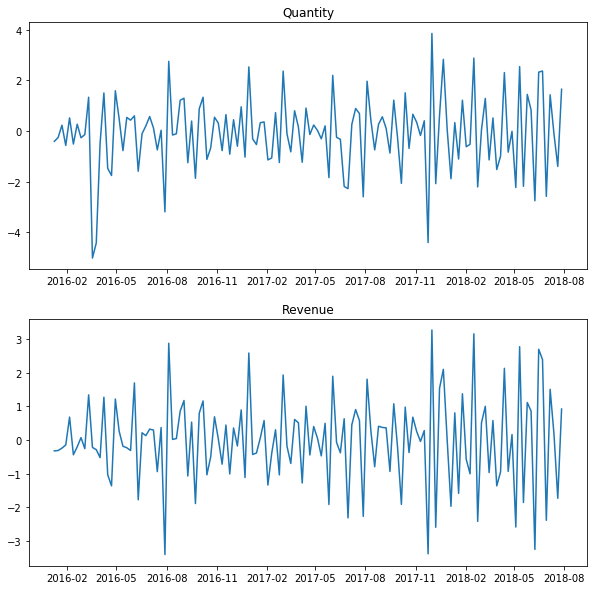

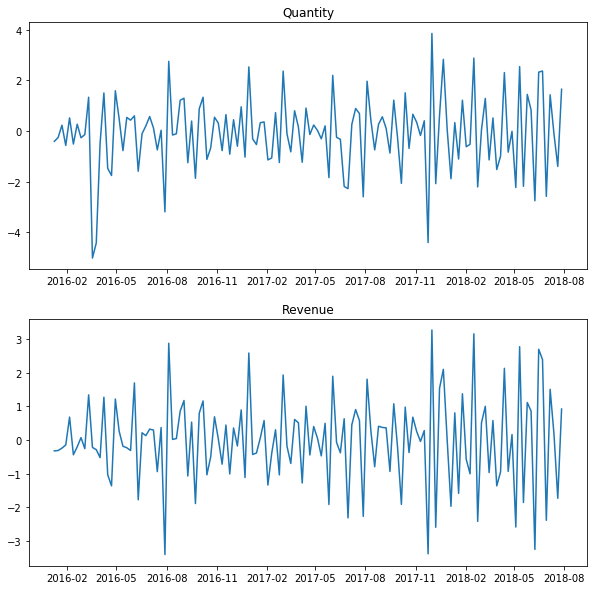

In [105]:
ans.plot()

<p><a name="ira"></a></p>
### Impulse Responses Analysis

In [106]:
irf = ans.irf(5)  # 5 stands for maxlag

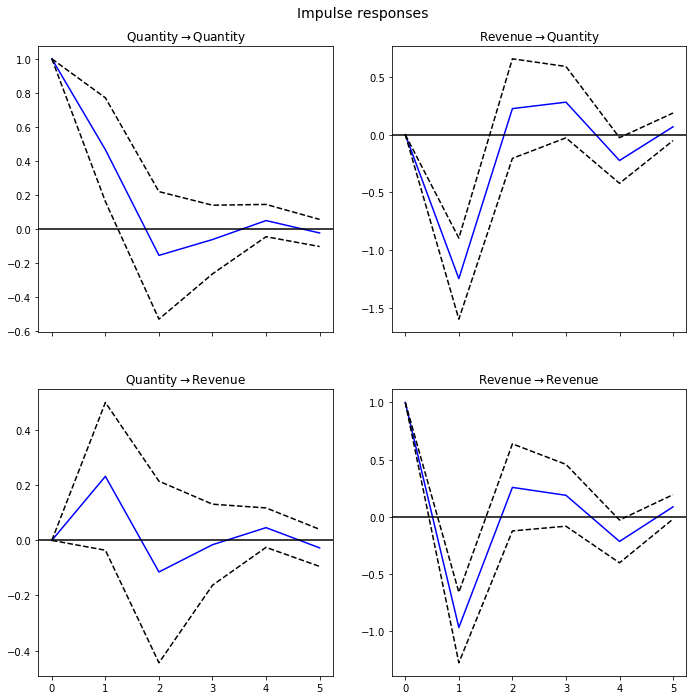

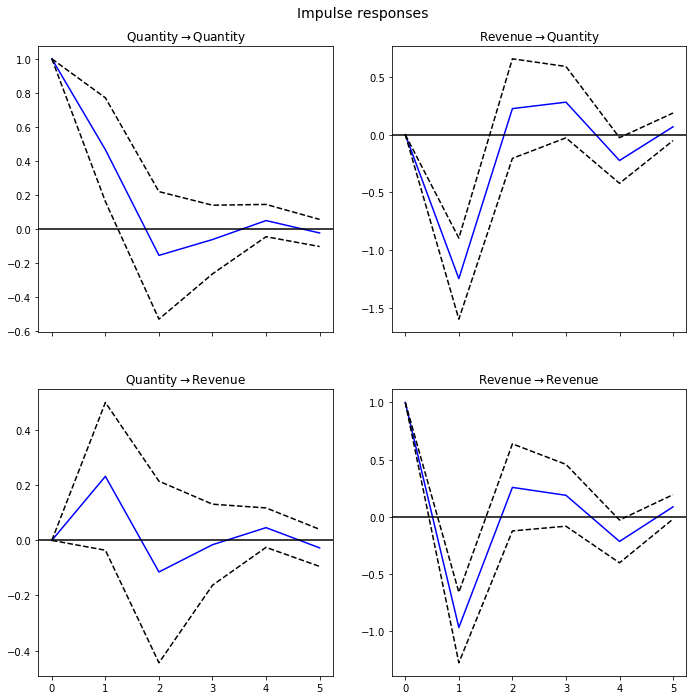

In [107]:
irf.plot()

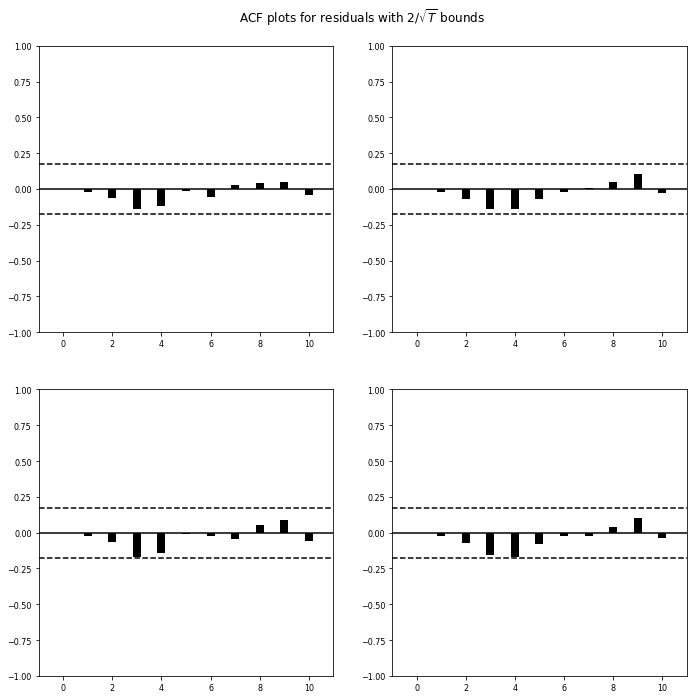

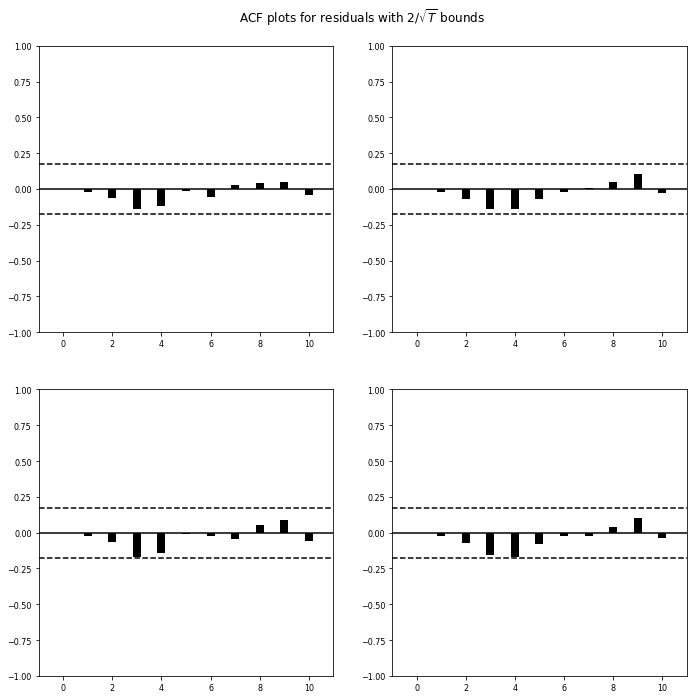

In [108]:
ans.plot_acorr()

<p><a name="sel"></a></p>
### Model Selection Through Information Criterion

In [109]:
 with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            model.select_order(10)

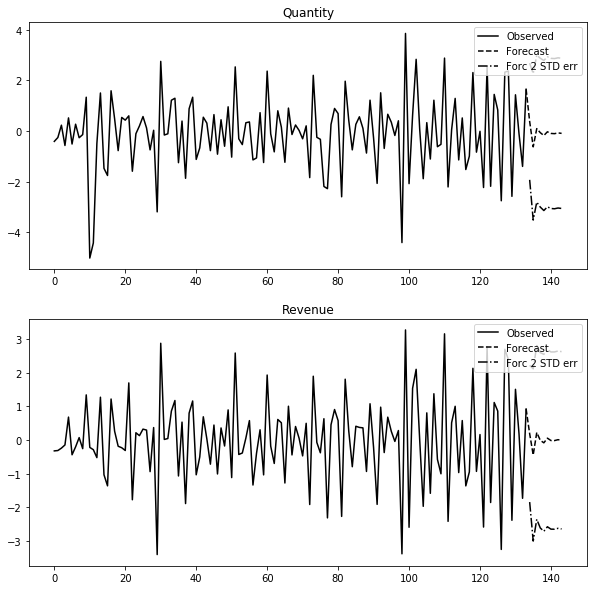

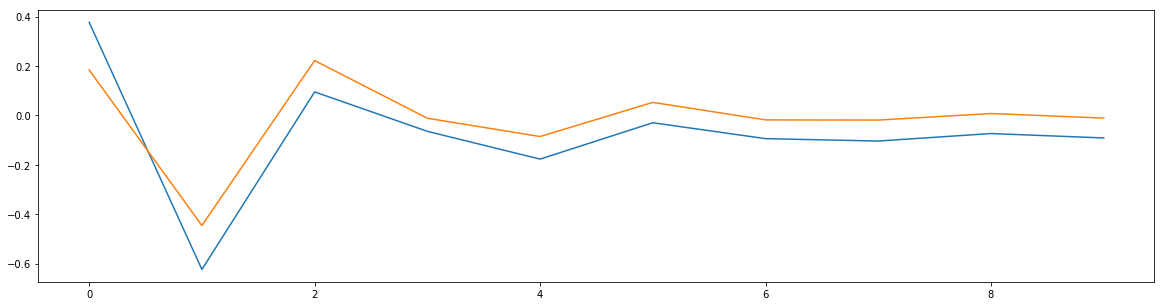

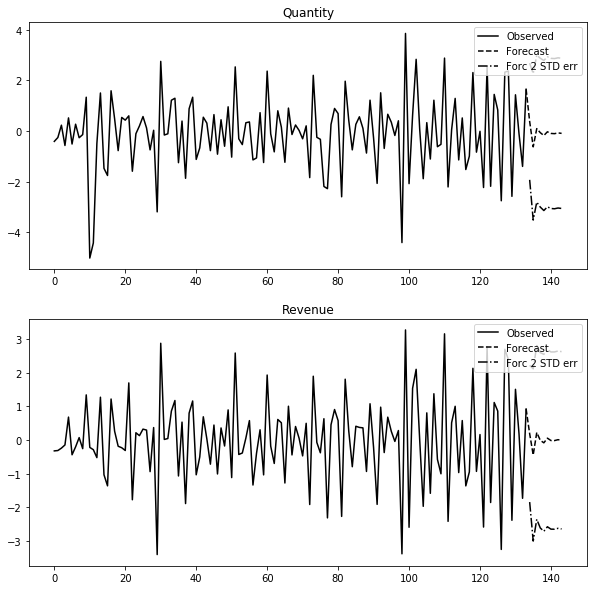

In [110]:
lag_order = ans.k_ar
f_values = ans.forecast(ret_train3[dat].values[-lag_order:,:], 10)
f_values.shape
plt.plot(np.arange(10), f_values[:,0])
plt.plot(np.arange(10), f_values[:,1])
ans.plot_forecast(10)

<p><a name="var"></a></p>
### Traning the VAR model through VARMAX with order = (p,0)

In [111]:
useExog = True
endo_tickers = ['Quantity','Revenue']
exog_tickers = endo_tickers
endo = ret_train3[endo_tickers]
exog = ret_train3[exog_tickers] if useExog else None
varmax  = VARMAX(endo, exog = exog, order=(12,0), start_params=None)

In [112]:
with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            result = varmax.fit(maxiter=1000)

LinAlgError: LU decomposition error.

In [113]:
warnings.filterwarnings('ignore', module='statsmodels')
result.summary()

/Users/hee-wonchang/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1543: RuntimeWarning: divide by zero encountered in true_divide
  return s[..., 0]/s[..., -1]


Dep. Variable:,"['Quantity', 'Revenue']",No. Observations:,134
Model:,VARX(1),Log Likelihood,-36756555641019998120279673577406464.000
,+ intercept,AIC,73513111282039996240559347154812928.000
Date:,"Wed, 05 Dec 2018",BIC,73513111282039996240559347154812928.000
Time:,16:18:45,HQIC,73513111282039996240559347154812928.000
Sample:,01-08-2016,,
,- 07-27-2018,,
Covariance Type:,opg,,
Ljung-Box (Q):,"92.09, 140.86",Jarque-Bera (JB):,"3.41, 1.86"
Prob(Q):,"0.00, 0.00",Prob(JB):,"0.18, 0.39"
Heteroskedasticity (H):,"2.25, 2.72",Skew:,"0.15, 0.23"


In [114]:
fitted_values = result.predict()   # in-sample prediction
fitted_values.head()

,Quantity,Revenue
Week,,
2016-01-08,-0.317305,-0.287300
2016-01-15,-0.294805,-0.277958
2016-01-22,-0.175970,-0.281132
2016-01-29,0.200109,-0.256008
2016-02-05,-0.434590,-0.092780


In [115]:
train_window = 250
order = (1, 0)
useExog = True
exog  = ret_train2[exog_tickers].iloc[:train_window] if useExog else None
endog = ret_train2[endo_tickers].iloc[:train_window]    
varmax = VARMAX(endog=endog, order=order, exog = exog)
with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            res2  = varmax.fit(maxiter=1000)

(144, 2)
(144, 2)


Text(0.5,1,'Revenue Actual vs Predicted Values')

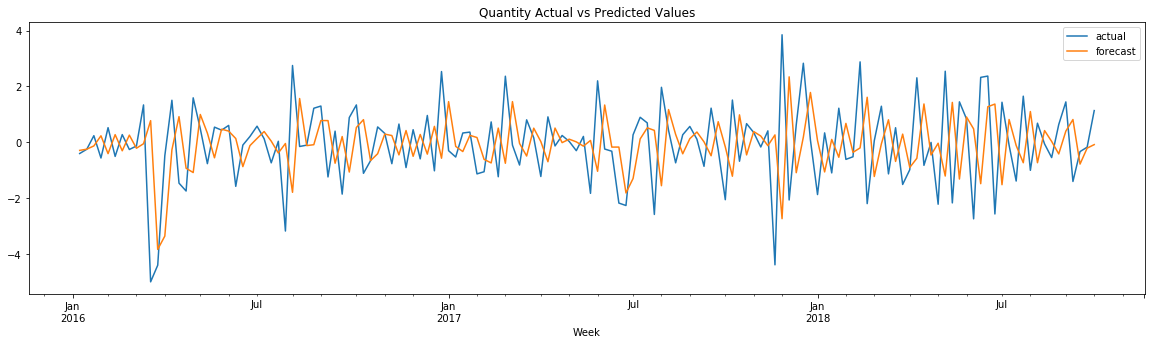

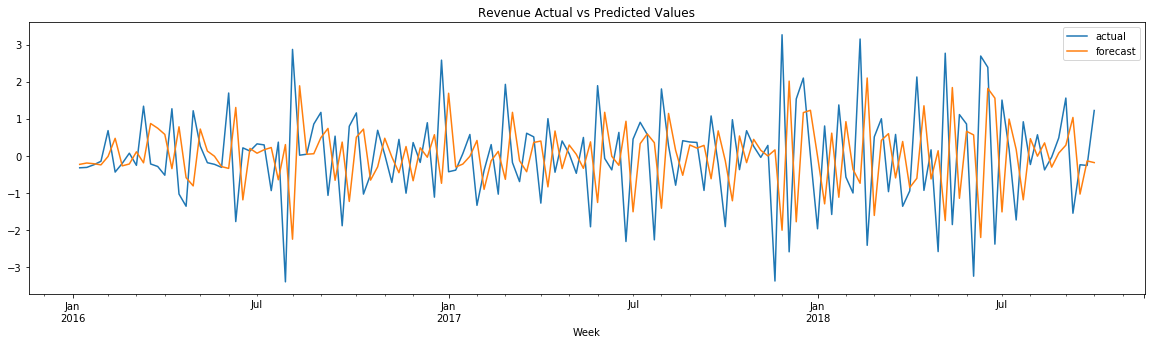

In [116]:
print(exog.shape)
print(endog.shape)
output = res2.predict()


qty = pd.DataFrame({'actual':endog.Quantity,'forecast':output.Quantity})
rev  = pd.DataFrame({'actual':endog.Revenue,'forecast':output.Revenue})
qty.plot()
plt.title('Quantity Actual vs Predicted Values')
rev.plot()
plt.title('Revenue Actual vs Predicted Values')

In [117]:
np.sqrt(np.mean((qty.actual-qty.forecast)**2))  #RMSE

1.8927832512248532

In [118]:
np.sqrt(np.mean((rev.actual-rev.forecast)**2))  #RMSE

1.86785909363041

In [119]:
endog.index

DatetimeIndex(['2016-01-08', '2016-01-15', '2016-01-22', '2016-01-29',
               '2016-02-05', '2016-02-12', '2016-02-19', '2016-02-26',
               '2016-03-04', '2016-03-11',
               ...
               '2018-08-03', '2018-08-10', '2018-08-17', '2018-08-24',
               '2018-08-31', '2018-09-07', '2018-09-14', '2018-09-21',
               '2018-09-28', '2018-10-05'],
              dtype='datetime64[ns]', name='Week', length=144, freq='W-FRI')

In [120]:
predictions = []
mse         = []

for i in range(0, ret_train2.shape[0]-train_window):
    loc   = slice(i, i+train_window)  # slice object abstracting start:end:step into an slice object
    
    endog = ret_train2[endo_tickers].iloc[loc]
    exog  = ret_train2[exog_tickers].iloc[loc] if useExog else None
    new_model = VARMAX(endog=endog, exog = exog, order=order)


    with warnings.catch_warnings():
            warnings.filterwarnings("ignore", module='statsmodels')
            res2 = new_model.fit(start_params=res2.params, disp=False,
                                 maxiter=1000, method='lbfgs')
            predicted_value = res2.predict()
            
    mse.append(((endog-predicted_value)**2).mean(axis=0))
    exog2 = exog.iloc[[-1]] if useExog else None
    predictions.append(res2.forecast(1, exog = exog2))
    if i%10 == 0:
        print('Finish the %3d-th rolling 1-step-ahead forecast' %(i))

predictions = pd.concat(predictions) 
mse         = pd.concat(mse, axis=1)
print("Terminated!")

ValueError: No objects to concatenate

<p><a name="mod2"></a></p>
## 3. Model by Category

<p><a name="vis2"></a></p>
### Visualization

In [77]:
#daily return
ret_var = np.log(uno_tsdf_cat).diff().iloc[1:]
ret_var    = ret_var.fillna(method='pad')
ret_train  = ret_var.copy()
ret_train.index = pd.to_datetime(ret_train.index)
ret_train.fillna(0, inplace=True)
ret_train.head()

/Users/hee-wonchang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


,Accessories,Bracelet,EarRings,Necklace,Ring
Date,,,,,
2016-01-05,1.814655,1.656034,0.491175,2.465789,0.0
2016-01-06,-1.684063,-2.368821,-1.915198,-2.654386,0.0
2016-01-07,-0.485188,1.849018,0.761990,1.190430,0.0
2016-01-08,-0.259816,0.164905,0.253293,-0.196178,0.0
2016-01-09,0.000000,0.000000,0.000000,0.000000,0.0


In [78]:
#weekly return
useGrouper = True
if useGrouper:
        grouper    = pd.Grouper(freq='W-FRI') #weekly, ending on Friday
        ret_train2 = ret_train.groupby(grouper).sum()
        ret_train2.head()
else:
        ret_train['week'] = ret_train.index.year * 52 + np.clip(ret_train.index.week, 0, 52.5)
        if 'Date' not in ret_train.columns: ret_train.reset_index(inplace=True)
        ret_train2 = ret_train.groupby('week').sum()
        ret_train2['week'] = ret_train.groupby('week').last()['Date']
        ret_train2 = ret_train2.set_index('week')
        print(ret_train2.head())


In [79]:
train_window = ret_train2.shape[0] - 10  # Use the full data set except the last 10 weeks
ret_train2.index.rename('Week',inplace=True)
ret_train3 = ret_train2.iloc[:train_window]

<p><a name="btv2"></a></p>
### Build and Train a VAR model 

In [81]:
dat = ['Accessories', 'Bracelet', 'EarRings', 'Necklace', 'Ring']
model = VAR(ret_train3[dat], dates=ret_train3.index)

In [86]:
import warnings
with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            ans = model.fit(2, ic = 'aic')  # 2 stands for maxlags

ValueError: On entry to DLASCL parameter number 4 had an illegal value

In [83]:
coefs = pd.DataFrame(ans.coefs[0], index= dat ,columns=map(lambda t:'L1.%s' %(t), dat))
print(coefs)

ValueError: Shape of passed values is (2, 2), indices imply (5, 5)

In [84]:
ans.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, Dec, 2018
Time:                     16:04:18
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.471315
Nobs:                     132.000    HQIC:                 -0.600964
Log likelihood:          -319.079    FPE:                   0.501758
AIC:                    -0.689709    Det(Omega_mle):        0.465802
--------------------------------------------------------------------
Results for equation Quantity
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.063114         0.103637           -0.609           0.543
L1.Quantity         0.466361         0.155366            3.002           0.003
L1.Revenue         -1.245344         0.178851           -6.963   

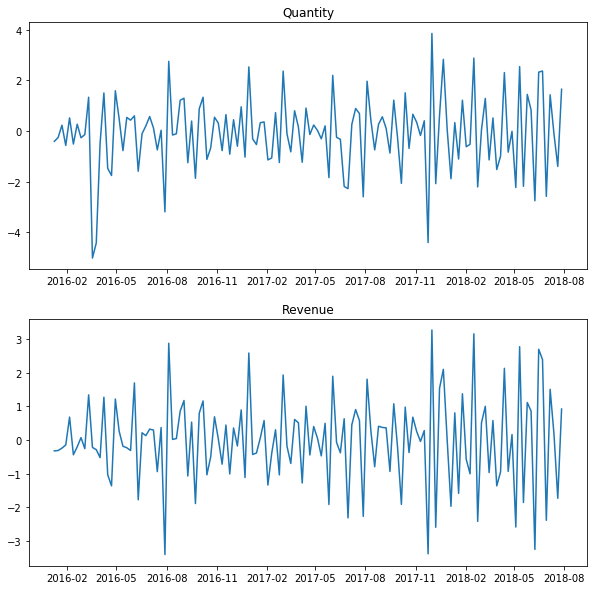

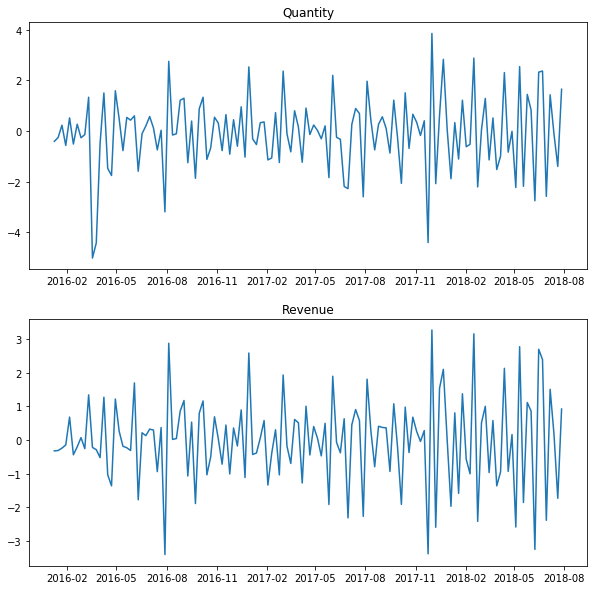

In [85]:
ans.plot()